# Imports

In [1]:
from nn import nn
from nn import preprocess
from nn import io
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np

# NN autoencoder on digits

In [2]:
# loading in digits data
digits = load_digits()
X = digits['data'] 

X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)

I decided to use a learning rate of .001. Going above that learning rate makes the test and validation loss a lot noisier (and too high the plot the loss doesn't actually decrease). Additionally, making the training rate much lower leads to a higher loss ultimate loss function. For batch size, I found I needed a relatively high batch size (more than ~400) for the nn to actually work, but beyond that, higher batch sizes didn't alter the output much beyond smooething out the loss curves. I kept epochs high enough that we would see the full smoothing out of the curve. 

I chose relu for the activation function, since the A matrices are not confined between 0 and 1.

In [3]:
# building and fitting nueral network
ae = nn.NeuralNetwork([{'input_dim': 64, 'output_dim': 16, 'activation': 'relu'}, 
                       {'input_dim': 16, 'output_dim': 64, 'activation': 'relu'}], 
                       .0001, 
                       10, 
                       1000, 
                       4000, 
                       'mse')

test_loss, val_loss = ae.fit(X_train.T, X_train.T, X_test.T,  X_test.T) 

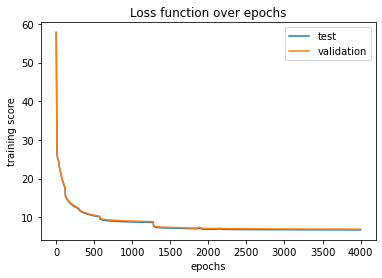

In [4]:
plt.plot(test_loss)
plt.plot(val_loss)
plt.title('Loss function over epochs')
plt.legend(['test', 'validation'])
plt.xlabel('epochs')
plt.ylabel('training score')
plt.show()

Here I am showing what the autoencoder can do, in recreating the images out the input numbers.

<Figure size 432x288 with 0 Axes>

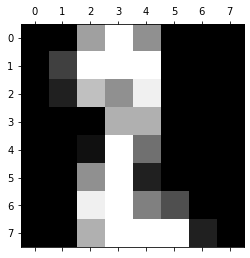

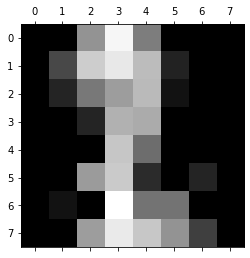

In [9]:
out = ae.predict(X_train)
out_img_train = out.flatten().reshape(1203, 8, 8)
in_img = X_train.flatten().reshape(1203, 8, 8)


plt.gray()
plt.matshow(in_img[6])
plt.matshow(out_img_train[6])



In [17]:
# average error
avg_error_train = np.mean(abs(X_train-ae.predict(X_train)))
avg_error_test = np.mean(abs(X_test-ae.predict(X_test)))
avg_error_all = (avg_error_test*len(X_test)+avg_error_train*len(X_train))/(len(X_test)+len(X_train))

print(f'average train error: {avg_error_train}')
print(f'average test error: {avg_error_test}')
print(f'average test all: {avg_error_all}')

average train error: 1.266431716068087
average test error: 1.2941170362872054
average test all: 1.2755831240870943


# Transcription Factor Classifier

I decided to use a learning rate of 3, as this lr allows the nn to obtain a low loss function for both training and validation quickly, and not overfit. Going much above that learning rate makes the test and validation reach 0 much later (and going much lower makes lowering the loss go very slow).
Changing the batch size did not have a significant change on the loss values, so I put it at 10, as this is less than the total number of input sequences. 

I chose sigmoid for the activation function, since the A matrices must be confined between 0 and 1 (as they are  being compared against y values that are 0 and 1).

I chose binary cross entropy for the loss function, since it is built to compare probabilities against a binary outpute of 0 or 1, which is the exact structure of the problem we have here

In [65]:
pos_seq_fn = './data/rap1-lieb-positives.txt'
neg_seq_fn = './data/yeast-upstream-1k-negative.fa'
pos_seq = io.read_text_file(pos_seq_fn)
neg_seq = io.read_fasta_file(neg_seq_fn)

all_seq = pos_seq+neg_seq
labels = np.append(np.ones(len(pos_seq)),np.zeros(len(neg_seq)))

In [112]:
pos_neg_seqs, pos_neg_labs = preprocess.sample_seqs(all_seq, 
                                         labels, 
                                         num_out_seqs='equal')
encoded_seqs = preprocess.one_hot_encode_seqs(pos_neg_seqs)

In [113]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq, = train_test_split(encoded_seqs,
                                                                     pos_neg_labs, 
                                                                     test_size=0.33, 
                                                                     random_state=42)

In [142]:
trans_nn = nn.NeuralNetwork([{'input_dim': 68, 'output_dim': 5, 'activation': 'sigmoid'}, 
                             {'input_dim': 5, 'output_dim': 1, 'activation': 'sigmoid'}], 
                             lr=3, 
                             seed = 10,
                             batch_size = 10,
                             epochs = 1000, 
                             loss_function='bce')

test_loss, val_loss= trans_nn.fit(np.array(X_train_seq).T, 
                                    np.array(y_train_seq).reshape(1, -1) ,
                                    np.array(X_test_seq).T,  
                                    np.array(y_test_seq).reshape(1, -1)) 




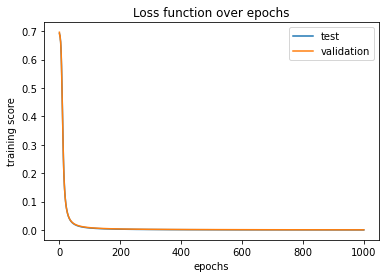

In [143]:
plt.plot(test_loss)
plt.plot(val_loss)
plt.title('Loss function over epochs')
plt.legend(['test', 'validation'])
plt.xlabel('epochs')
plt.ylabel('training score')
plt.show()

In [169]:
prediction_train = trans_nn.predict(np.array(X_train_seq)).flatten()
predictions_bin_train = 1*(prediction_train>.5)
prediction_test = trans_nn.predict(np.array(X_test_seq)).flatten()
predictions_bin_test = 1*(prediction_test>.5)
accuracy_train = 100 - 100*sum(abs(predictions_bin_train-y_train_seq))/len(y_train_seq)
accuracy_test = 100 - 100*sum(abs(predictions_bin_test-y_test_seq))/len(y_test_seq)

print(f'accuracy on training data: {accuracy_train}%')
print(f'accuracy on testing data: {accuracy_test}%')

accuracy on training data: 100.0%
accuracy on testing data: 100.0%
